<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Pipeline Notebook #

**Authors**: David Law, Kirsten Larson; MIRI branch<br>
**Last Updated**: July 16, 2025<br>
**Pipeline Version**: 1.19.1 (Build 12.0)

**Purpose**:<BR>
This notebook provides a framework for processing generic Mid-Infrared
Instrument (MIRI) Medium Resolution Spectroscopy (MRS) data through all
three James Webb Space Telescope (JWST) pipeline stages.  Data is assumed
to be located in two observation folders (science and background)
according to paths set up below.  It should not be necessary to edit any
cells other than in the [Configuration](#1.-Configuration) section
unless modifying the standard pipeline processing options.

**Data**:<BR>
This example is set up to use observations of the LMC planetary nebula
SMP LMC 058 obtained by Proposal ID (PID) 1523 Observation 3. This is a
point source that uses a standard 4-point dither in all three grating
settings.  It incorporates a dedicated background in observation 4.
Example input data to use will be downloaded automatically unless
disabled (i.e., to use local files instead).

**JWST pipeline version and CRDS context**:<BR>
This notebook was written for the
calibration pipeline version given above.  If you use it with a different pipeline
version or specify a non-default reference file context please see the relevant
release notes
([here for pipeline](https://github.com/spacetelescope/jwst),
[here for CRDS](https://jwst-crds.stsci.edu/)) for possibly relevant
changes.<BR>

**Updates**:<BR>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
Jan 16 2025: Update to Build 11.2 (jwst 1.17.1); no significant changes.<br>
May 5 2025: Update to Build 11.3 (jwst 1.18.0); add optional command to remove residual showers, plot spectra from updated x1d.fits data model with rf-corrected columns.<br>
May 22 2025: Update example plot use of regular and rf-corrected spectra.<br>
July 16 2025: No significant updates.<br>
Sep 03 2025: Minor update to remove mrs_imatch step

<hr style="border:1px solid gray"> </hr>

## Table of Contents

1. [Configuration](#1.-Configuration)
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
5. [Detector1 Pipeline](#5.-Detector1-Pipeline)
6. [Spec2 Pipeline](#6.-Spec2-Pipeline)
7. [Spec3 Pipeline](#7.-Spec3-Pipeline)
8. [Plot the spectra](#8.-Plot-the-spectra)

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration<a class="anchor" id="intro"></a>
------------------
Set basic parameters to use with notebook. These will affect
what data is used, where data is located (if already in disk),
pipeline modules run in this data, and type of background
subtraction (if any). The list of parameters are:

* demo_mode
* channel
* band
* directories with data
* pipeline modules
* Backgroud subtraction method

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this mode this
notebook will download example data from the
Barbara A. Mikulski Archive for Space Telescopes (MAST) and process it through the pipeline.
This will all happen in a local directory unless modified
in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below. 

Set <code>demo_mode = False</code> if you want to process your own data that has already
been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode, channel, band, data mode directories, and 
# processing steps.

# -----------------------------Demo Mode---------------------------------
demo_mode = False

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    user_home_dir = os.path.expanduser('~')

    # Point to where science observation data are
    # Assumes uncalibrated data in sci_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    sci_dir = os.path.join(user_home_dir, 'FlightData/APT1523/data/Obs003/')

    # Point to where background observation data are
    # Assumes uncalibrated data in bg_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    bg_dir = os.path.join(user_home_dir, 'FlightData/APT1523/data/Obs004/')
    #bg_dir = '' # If no background observation, use an empty string

# --------------------------Set Processing Steps--------------------------
# Whether or not to process only data from a given MRS band/channel (useful
# if overriding reference files)
# Note that BOTH parameters must be set in order to work
use_ch = ''  # '12' or '34'
use_band = ''  # 'SHORT', 'MEDIUM', or 'LONG'

# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dospec3 = True  # calwebb_spec3
doviz = True # Visualize calwebb_spec3 results

# Background processing
dodet1bg = True  # calwebb_detector1
dospec2bg = True  # calwebb_spec2 (needed for Master Background subtraction)

# How should background subtraction using any dedicated backgrounds be done?
# If none are selected, cubes will not be background subtracted.  1d spectra
# will always use local annular background subtraction for point sources.
# Note that if using master-background subtraction, background observations
# must be selected above to process through spec2 (dospec2bg = True).
master_bg = True  # Master-background subtraction in spec3 (subtract spectrum generated from the backgrounds).  This is the default pipeline setting.
pixel_bg = False  # Pixel-based background subtraction in spec2 (direct pixel subtraction).

### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the root directory for the local CRDS cache directory has not been set already, it will be set to create one in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------

# Set CRDS reference file context.  Leave commented-out to use the default context
# (latest reference files associated with the calibration pipeline version)
# or set a specific context here.
#%env CRDS_CONTEXT  jwst_1295.pmap

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
# if (os.getenv('CRDS_PATH') is None):
#     os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
os.environ["CRDS_PATH"] = "/home/cysil/JWST/projects/IFU_MRS/crds_cache"

# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path and context in use
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/cysil/JWST/projects/IFU_MRS/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2.<font color='white'>-</font>Package Imports<a class="anchor" id="intro"></a>
------------------

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import copy
import time
from pathlib import Path

# Numpy for doing calculations
import numpy as np

# -----------------------Astropy Imports-----------------------------------
# Astropy utilities for opening FITS and ASCII files, and downloading demo files
from astropy.io import fits
from astroquery.mast import Observations

# -----------------------Plotting Imports----------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
# --------------JWST Calibration Pipeline Imports---------------------------
# Import the base JWST and calibration reference data packages
import jwst
import crds

# JWST pipelines (each encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from jwst import datamodels  # JWST datamodels
from jwst.associations import asn_from_list as afl  # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

from jwst.stpipe import Step  # Import the wrapper class for pipeline steps

# Echo pipeline version and CRDS context in use
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print("Using CRDS Context = {}".format(crds.get_context_name('jwst')))

JWST Calibration Pipeline Version = 1.19.2
Using CRDS Context = jwst_1413.pmap


### Define convenience functions

In [7]:
# Define a convenience function to select only files of a given channel/band from an input set
def select_ch_band_files(files, use_ch, use_band):
    if ((use_ch != '') & (use_band != '')):
        keep = np.zeros(len(files))
        for ii in range(0, len(files)):
            with fits.open(files[ii]) as hdu:
                hdu.verify()
                hdr = hdu[0].header
                if ((hdr['CHANNEL'] == use_ch) & (hdr['BAND'] == use_band)):
                    keep[ii] = 1
        indx = np.where(keep == 1)
        files_culled = files[indx]
    else:
        files_culled = files
        
    return files_culled

In [8]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Demo Mode Setup<a class="anchor" id="intro"></a> (ignore if not using demo data)
------------------
If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [9]:
# Set up the program information and paths for demo program
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST!')
    program = "01523"
    sci_observtn = "003"
    back_observtn = "004"
    visit = "001"
    basedir = os.path.join('.', 'mrs_demo_data')
    download_dir = basedir
    sci_dir = os.path.join(basedir, 'Obs' + sci_observtn)
    bg_dir = os.path.join(basedir, 'Obs' + back_observtn)
    uncal_dir = os.path.join(sci_dir, 'uncal')
    uncal_bgdir = os.path.join(bg_dir, 'uncal')

    # Ensure filepaths for input data exist
    if not os.path.exists(uncal_dir):
        os.makedirs(uncal_dir)
    if not os.path.exists(uncal_bgdir):
        os.makedirs(uncal_bgdir)

Identify list of science (SCI) and background (BG) uncalibrated files associated with visits.
<div class="alert alert-block alert-warning">
Selects only <i>mirifu</i> data (ignores MIRI imager).
</div>

In [10]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    # Science data
    sci_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IFU"],
                                                   provenance_name=["CALJWST"],  # Executed observations
                                                   obs_id=['jw' + program + '-o' + sci_observtn + '*']
                                                   )

    # Background data
    bg_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IFU"],
                                                  provenance_name=["CALJWST"],  # Executed observations
                                                  obs_id=['jw' + program + '-o' + back_observtn + '*']
                                                  )

In [11]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE', 'productSubGroupDescription': 'UNCAL', 'calib_level': [1]}}

    # Science files
    sci_files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (sci_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            sci_files_to_download.extend(filtered_products['dataURI'])

    # Background files
    bg_files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (bg_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            bg_files_to_download.extend(filtered_products['dataURI'])

    # Cull to a unique list of files that contain 'mirifu' in the filename
    # (i.e., not MIRI imager)
    sci_files_to_download = np.unique([i for i in sci_files_to_download if 'mirifu' in i])
    bg_files_to_download = np.unique([i for i in bg_files_to_download if 'mirifu' in i])

    print("Science files selected for downloading: ", len(sci_files_to_download))
    print("Background selected for downloading: ", len(bg_files_to_download))

Download all the uncal files and place them into the appropriate directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file may be incomplete, and cause crashes later on!
</div>

In [12]:
if demo_mode:
    for filename in sci_files_to_download:
        sci_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_dir, Path(filename).name))
    for filename in bg_files_to_download:
        bg_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_bgdir, Path(filename).name))

<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Directory Setup<a class="anchor" id="intro"></a>
------------------
Set up detailed paths to input/output stages here.

In [13]:
# Define Local directory
sci_dir = '/home/cysil/JWST/projects/IFU_MRS/Data/Source/'
bg_dir = '/home/cysil/JWST/projects/IFU_MRS/Data/Background/'

# Define output subdirectories to keep science data products organized
uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
spec2_dir = os.path.join(sci_dir, 'stage2')  # calwebb_spec2 pipeline outputs will go here
spec3_dir = os.path.join(sci_dir, 'stage3')  # calwebb_spec3 pipeline outputs will go here

# Output subdirectories to keep background data products organized
uncal_bgdir = os.path.join(bg_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_bgdir = os.path.join(bg_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
spec2_bgdir = os.path.join(bg_dir, 'stage2')  # calwebb_spec2 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)
if (bg_dir != ''):
    if not os.path.exists(det1_bgdir):
        os.makedirs(det1_bgdir)
    if not os.path.exists(spec2_bgdir):
        os.makedirs(spec2_bgdir)

<div class="alert alert-block alert-warning">
If there is no background folder, ensure we don't try to process it.
</div>

In [14]:
if (bg_dir == ''):
    dodet1bg = False
    dospec2bg = False

In [15]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 0.0715 seconds


<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Detector1 Pipeline<a class="anchor" id="det1"></a>
------------------
In this section we process our data through the calwebb_detector1
pipeline to create Stage 1 data products (i.e., uncalibrated slope
images of the form *rate.fits).  These data products have units of DN/s.<BR><BR>
See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_detector1

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples provided below.<br>
E.g., turn on detection of cosmic ray showers.
</div>

In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'], det1dict['saturation'], det1dict['ipc'] = {}, {}, {}, {}, {}
det1dict['firstframe'], det1dict['lastframe'], det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['charge_migration'], det1dict['jump'], det1dict['ramp_fit'] = {}, {}, {}, {}, {}
det1dict['gain_scale'] = {}

# Overrides for whether or not certain steps should be skipped (example)
#det1dict['emicorr']['skip'] = True

# Option to use the first frame for very bright MIRI data that otherwise saturates fast enough to provide no slope
#det1dict['firstframe']['bright_use_group1'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits' # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits' # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits' # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits' # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits' # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits' # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits' # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits' # Read noise used by ramp fitting step

# Turn on multi-core processing for jump step (off by default).  Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half'

# Toggle detection of cosmic ray showers if desired (on by default)
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['find_showers'] = True
det1dict['jump']['extend_snr_threshold'] = 1.4

<div class="alert alert-block alert-warning">
Below an example of how to insert custom pipeline steps using the
pre-hook/post-hook framework.

For more information see [Tips and Trick for working with the JWST Pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/tips-and-tricks-for-working-with-the-jwst-pipeline)
    </div>

In [17]:
# Define a new step called XplyStep that multiplies everything by 1.0
# I.e., it does nothing, but could be changed to do something more interesting.
class XplyStep(Step):
    spec = '''
    '''
    class_alias = 'xply'

    def process(self, input_data):
        with datamodels.open(input_data) as model:
            result = model.copy()
        sci = result.data
        sci = sci * 1.0
        result.data = sci
        self.log.info('Multiplied everything by one in custom step!')
        return result


# And here we'll insert it into our pipeline dictionary to be run at the end right after the gain_scale step
det1dict['gain_scale']['post_hooks'] = [XplyStep]

### Calibrating Science Files
Look for input science files and run calwebb_detector1 pipeline using the call method.

In [18]:
# Look for input files of the form *uncal.fits from the science observation
sstring = os.path.join(uncal_dir, 'jw*mirifu*uncal.fits')
uncal_files = np.array(sorted(glob.glob(sstring)))
# Check that these are the band/channel to use
uncal_files = select_ch_band_files(uncal_files, use_ch, use_band)

print('Found ' + str(len(uncal_files)) + ' science input files')

Found 24 science input files


In [19]:
# Run the pipeline on these input files by a simple loop over files using
# our custom parameter dictionary
if dodet1:
    for file in uncal_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_dir)
else:
    print('Skipping Detector1 processing for SCI data')

2025-10-26 22:34:24,478 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf
2025-10-26 22:34:24,497 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf
2025-10-26 22:34:24,507 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf
2025-10-26 22:34:24,519 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf
2025-10-26 22:34:24,536 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-10-26 22:34:24,537 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-10-26 22:34:24,538 - stpipe.Detector1Pipeline.dq_init - INFO

2025-10-26 22:34:24,686 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:34:24,689 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:34:24,689 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:34:24,689 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2025-10-26 22:34:24,690 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:34:36,069 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:34:36,069 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:34:36,747 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:34:36,851 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00001_mirifulong_uncal.fits>,).
2025-10-26 22:34:36,851 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:34:36,949 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00001_mirifulong_uncal.fits>,).
2025-10-26 22:34:36,950 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:34:37,052 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:34:59,535 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:34:59,535 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:34:59,536 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:34:59,537 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:34:59,537 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:34:59,539 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:34:59,540 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:34:59,540 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:34:59,541 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:34:59,542 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:34:59,681 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:34:59,684 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:34:59,684 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0054.fits'.
2025-10-26 22:34:59,684 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:34:59,685 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:35:10,917 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:35:10,917 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:35:11,538 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:35:11,636 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00001_mirifushort_uncal.fits>,).
2025-10-26 22:35:11,637 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:35:11,736 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00001_mirifushort_uncal.fits>,).
2025-10-26 22:35:11,736 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:35:11,833 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:35:34,380 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:35:34,381 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:35:34,382 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:35:34,383 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:35:34,384 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:35:34,385 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:35:34,386 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:35:34,387 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:35:34,388 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:35:34,389 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:35:34,528 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:35:34,530 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:35:34,531 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:35:34,531 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2025-10-26 22:35:34,532 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:35:39,050 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:35:39,050 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:35:39,783 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:35:39,883 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00002_mirifulong_uncal.fits>,).
2025-10-26 22:35:39,884 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:35:39,981 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00002_mirifulong_uncal.fits>,).
2025-10-26 22:35:39,982 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:35:40,090 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:36:02,973 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:36:02,974 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:36:02,975 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:36:02,976 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:36:02,977 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:36:02,979 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:36:02,980 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:36:02,981 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:36:02,981 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:36:02,982 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:36:03,116 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:36:03,119 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:36:03,119 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0054.fits'.
2025-10-26 22:36:03,119 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:36:03,120 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:36:07,645 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:36:07,645 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:36:08,292 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:36:08,390 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00002_mirifushort_uncal.fits>,).
2025-10-26 22:36:08,390 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:36:08,487 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00002_mirifushort_uncal.fits>,).
2025-10-26 22:36:08,487 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:36:08,584 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:36:32,213 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:36:32,214 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:36:32,215 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:36:32,215 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:36:32,216 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:36:32,218 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:36:32,219 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:36:32,220 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:36:32,221 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:36:32,222 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:36:32,360 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:36:32,362 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:36:32,363 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:36:32,363 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2025-10-26 22:36:32,364 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:36:36,945 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:36:36,945 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:36:37,675 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:36:37,773 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00003_mirifulong_uncal.fits>,).
2025-10-26 22:36:37,774 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:36:37,870 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00003_mirifulong_uncal.fits>,).
2025-10-26 22:36:37,871 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:36:37,967 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:37:01,839 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:37:01,840 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:37:01,840 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:37:01,841 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:37:01,842 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:37:01,844 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:37:01,845 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:37:01,846 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:37:01,846 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:37:01,847 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:37:01,988 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:37:01,991 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:37:01,992 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0054.fits'.
2025-10-26 22:37:01,992 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:37:01,993 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:37:06,683 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:37:06,684 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:37:07,325 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:37:07,424 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00003_mirifushort_uncal.fits>,).
2025-10-26 22:37:07,425 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:37:07,522 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00003_mirifushort_uncal.fits>,).
2025-10-26 22:37:07,523 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:37:07,620 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:37:31,661 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:37:31,663 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:37:31,664 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:37:31,664 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:37:31,666 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:37:31,667 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:37:31,668 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:37:31,669 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:37:31,670 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:37:31,670 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:37:31,806 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:37:31,808 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:37:31,809 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:37:31,809 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2025-10-26 22:37:31,810 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:37:36,536 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:37:36,537 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:37:37,302 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:37:37,402 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00004_mirifulong_uncal.fits>,).
2025-10-26 22:37:37,403 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:37:37,500 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00004_mirifulong_uncal.fits>,).
2025-10-26 22:37:37,500 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:37:37,600 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:38:01,842 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:38:01,843 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:38:01,844 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:38:01,845 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:38:01,846 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:38:01,847 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:38:01,848 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:38:01,849 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:38:01,850 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:38:01,851 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:38:01,987 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02101_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:38:01,990 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:38:01,990 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0054.fits'.
2025-10-26 22:38:01,990 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:38:01,991 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:38:06,588 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:38:06,588 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:38:07,243 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:38:07,342 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00004_mirifushort_uncal.fits>,).
2025-10-26 22:38:07,342 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:38:07,443 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02101_00004_mirifushort_uncal.fits>,).
2025-10-26 22:38:07,444 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:38:07,546 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:38:31,685 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:38:31,686 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:38:31,687 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:38:31,688 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:38:31,688 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:38:31,690 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:38:31,691 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:38:31,692 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:38:31,693 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:38:31,693 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:38:31,832 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:38:31,834 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:38:31,835 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:38:31,835 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2025-10-26 22:38:31,835 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:38:36,628 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:38:36,628 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:38:37,397 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:38:37,500 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00001_mirifulong_uncal.fits>,).
2025-10-26 22:38:37,501 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:38:37,605 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00001_mirifulong_uncal.fits>,).
2025-10-26 22:38:37,606 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:38:37,708 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:39:02,632 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:39:02,633 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:39:02,633 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:39:02,634 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:39:02,635 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:39:02,636 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:39:02,637 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:39:02,638 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:39:02,639 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:39:02,640 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:39:02,781 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:39:02,784 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:39:02,784 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:39:02,785 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:39:02,785 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:39:07,544 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:39:07,544 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:39:08,241 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:39:08,348 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00001_mirifushort_uncal.fits>,).
2025-10-26 22:39:08,348 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:39:08,451 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00001_mirifushort_uncal.fits>,).
2025-10-26 22:39:08,451 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:39:08,559 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:39:32,586 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:39:32,587 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:39:32,588 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:39:32,589 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:39:32,589 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:39:32,591 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:39:32,592 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:39:32,593 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:39:32,594 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:39:32,594 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:39:32,738 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:39:32,741 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:39:32,742 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:39:32,742 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2025-10-26 22:39:32,743 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:39:37,367 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:39:37,368 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:39:38,115 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:39:38,219 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00002_mirifulong_uncal.fits>,).
2025-10-26 22:39:38,220 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:39:38,323 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00002_mirifulong_uncal.fits>,).
2025-10-26 22:39:38,323 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:39:38,426 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:40:02,495 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:40:02,496 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:40:02,496 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:40:02,497 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:40:02,498 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:40:02,499 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:40:02,500 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:40:02,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:40:02,502 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:40:02,502 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:40:02,639 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:40:02,642 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:40:02,642 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:40:02,643 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:40:02,643 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:40:07,357 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:40:07,358 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:40:08,066 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:40:08,172 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00002_mirifushort_uncal.fits>,).
2025-10-26 22:40:08,173 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:40:08,277 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00002_mirifushort_uncal.fits>,).
2025-10-26 22:40:08,278 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:40:08,383 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:40:32,411 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:40:32,411 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:40:32,412 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:40:32,413 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:40:32,414 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:40:32,415 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:40:32,416 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:40:32,417 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:40:32,418 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:40:32,418 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:40:32,557 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:40:32,560 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:40:32,560 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:40:32,561 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2025-10-26 22:40:32,561 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:40:37,115 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:40:37,116 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:40:37,864 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:40:37,974 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00003_mirifulong_uncal.fits>,).
2025-10-26 22:40:37,975 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:40:38,080 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00003_mirifulong_uncal.fits>,).
2025-10-26 22:40:38,081 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:40:38,186 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:41:02,465 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:41:02,466 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:41:02,467 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:41:02,467 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:41:02,468 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:41:02,470 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:41:02,471 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:41:02,472 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:41:02,472 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:41:02,473 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:41:02,620 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:41:02,623 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:41:02,624 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:41:02,624 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:41:02,624 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:41:07,178 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:41:07,178 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:41:07,882 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:41:07,989 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00003_mirifushort_uncal.fits>,).
2025-10-26 22:41:07,989 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:41:08,096 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00003_mirifushort_uncal.fits>,).
2025-10-26 22:41:08,097 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:41:08,199 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:41:32,772 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:41:32,773 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:41:32,774 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:41:32,775 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:41:32,777 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:41:32,778 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:41:32,780 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:41:32,781 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:41:32,782 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:41:32,783 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:41:32,923 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:41:32,925 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:41:32,925 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:41:32,926 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2025-10-26 22:41:32,926 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:41:37,586 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:41:37,586 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:41:38,308 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:41:38,412 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00004_mirifulong_uncal.fits>,).
2025-10-26 22:41:38,412 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:41:38,515 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00004_mirifulong_uncal.fits>,).
2025-10-26 22:41:38,515 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:41:38,615 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:42:02,987 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:42:02,988 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:42:02,989 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:42:02,990 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:42:02,990 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:42:02,992 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:42:02,993 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:42:02,994 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:42:02,994 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:42:02,995 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:42:03,136 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02103_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:42:03,139 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:42:03,139 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:42:03,140 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:42:03,140 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:42:07,768 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:42:07,769 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:42:08,450 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:42:08,560 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00004_mirifushort_uncal.fits>,).
2025-10-26 22:42:08,561 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:42:08,667 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02103_00004_mirifushort_uncal.fits>,).
2025-10-26 22:42:08,667 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:42:08,774 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:42:32,899 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:42:32,900 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:42:32,901 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:42:32,901 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:42:32,902 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:42:32,903 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:42:32,904 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:42:32,905 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:42:32,906 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:42:32,907 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:42:33,048 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:42:33,051 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:42:33,051 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0033.fits'.
2025-10-26 22:42:33,052 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2025-10-26 22:42:33,052 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:42:37,754 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:42:37,754 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:42:38,518 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:42:38,625 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00001_mirifulong_uncal.fits>,).
2025-10-26 22:42:38,626 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:42:38,729 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00001_mirifulong_uncal.fits>,).
2025-10-26 22:42:38,730 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:42:38,835 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:43:03,607 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:43:03,608 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:43:03,609 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:43:03,609 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:43:03,610 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:43:03,611 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:43:03,612 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:43:03,614 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:43:03,614 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:43:03,615 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:43:03,759 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:43:03,762 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:43:03,762 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:43:03,762 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:43:03,763 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:43:08,383 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:43:08,383 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:43:09,061 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:43:09,165 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00001_mirifushort_uncal.fits>,).
2025-10-26 22:43:09,165 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:43:09,270 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00001_mirifushort_uncal.fits>,).
2025-10-26 22:43:09,270 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:43:09,372 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:43:33,806 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:43:33,807 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:43:33,808 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:43:33,809 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:43:33,810 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:43:33,811 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:43:33,812 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:43:33,814 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:43:33,814 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:43:33,815 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:43:33,965 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:43:33,968 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:43:33,969 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0033.fits'.
2025-10-26 22:43:33,969 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2025-10-26 22:43:33,970 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:43:38,663 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:43:38,664 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:43:39,451 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:43:39,559 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00002_mirifulong_uncal.fits>,).
2025-10-26 22:43:39,560 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:43:39,663 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00002_mirifulong_uncal.fits>,).
2025-10-26 22:43:39,663 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:43:39,769 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:44:04,853 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:44:04,854 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:44:04,854 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:44:04,855 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:44:04,856 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:44:04,857 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:44:04,858 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:44:04,859 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:44:04,860 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:44:04,861 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:44:05,008 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:44:05,011 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:44:05,011 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:44:05,012 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:44:05,012 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:44:09,667 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:44:09,668 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:44:10,321 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:44:10,423 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00002_mirifushort_uncal.fits>,).
2025-10-26 22:44:10,424 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:44:10,527 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00002_mirifushort_uncal.fits>,).
2025-10-26 22:44:10,528 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:44:10,629 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:44:34,582 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:44:34,583 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:44:34,584 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:44:34,585 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:44:34,586 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:44:34,587 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:44:34,588 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:44:34,589 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:44:34,590 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:44:34,591 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:44:34,734 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:44:34,736 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:44:34,737 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0033.fits'.
2025-10-26 22:44:34,737 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2025-10-26 22:44:34,738 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:44:39,234 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:44:39,234 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:44:39,954 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:44:40,056 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00003_mirifulong_uncal.fits>,).
2025-10-26 22:44:40,056 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:44:40,156 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00003_mirifulong_uncal.fits>,).
2025-10-26 22:44:40,156 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:44:40,259 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:45:04,613 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:45:04,614 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:45:04,614 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:45:04,615 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:45:04,616 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:45:04,617 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:45:04,618 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:45:04,619 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:45:04,620 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:45:04,621 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:45:04,764 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:45:04,767 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:45:04,768 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:45:04,768 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:45:04,769 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:45:09,324 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:45:09,324 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:45:09,973 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:45:10,076 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00003_mirifushort_uncal.fits>,).
2025-10-26 22:45:10,076 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:45:10,176 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00003_mirifushort_uncal.fits>,).
2025-10-26 22:45:10,177 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:45:10,278 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:45:34,989 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:45:34,990 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:45:34,991 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:45:34,992 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:45:34,994 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:45:34,995 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:45:34,997 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:45:34,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:45:34,999 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:45:35,001 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:45:35,147 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:45:35,150 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:45:35,151 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0033.fits'.
2025-10-26 22:45:35,151 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2025-10-26 22:45:35,152 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:45:39,678 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:45:39,678 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:45:40,408 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:45:40,509 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00004_mirifulong_uncal.fits>,).
2025-10-26 22:45:40,510 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:45:40,610 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00004_mirifulong_uncal.fits>,).
2025-10-26 22:45:40,611 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:45:40,710 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:46:05,383 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:46:05,384 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:46:05,384 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:46:05,385 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:46:05,386 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:46:05,387 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:46:05,388 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:46:05,389 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:46:05,390 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:46:05,391 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:46:05,546 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732004001_02105_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:46:05,549 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:46:05,550 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:46:05,550 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:46:05,550 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:46:10,091 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:46:10,091 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:46:10,749 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:46:10,849 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00004_mirifushort_uncal.fits>,).
2025-10-26 22:46:10,850 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:46:10,950 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732004001_02105_00004_mirifushort_uncal.fits>,).
2025-10-26 22:46:10,951 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:46:11,051 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

### Calibrating Background Files
Look for input background files and run calwebb_detector1
pipeline using the call method.

In [20]:
# Now let's look for input files of the form *uncal.fits from the background
# observations
sstring = os.path.join(uncal_bgdir, 'jw*mirifu*uncal.fits')
uncal_files = np.array(sorted(glob.glob(sstring)))
# Check that these are the band/channel to use
uncal_files = select_ch_band_files(uncal_files, use_ch, use_band)

print('Found ' + str(len(uncal_files)) + ' background input files')

Found 12 background input files


In [21]:
# Run the pipeline on these input files by a simple loop over files using
# our custom parameter dictionary
if dodet1bg:
    for file in uncal_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_bgdir)
else:
    print('Skipping Detector1 processing for BG data')

2025-10-26 22:46:35,302 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf
2025-10-26 22:46:35,318 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf
2025-10-26 22:46:35,329 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-jumpstep_0007.asdf
2025-10-26 22:46:35,341 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0010.asdf
2025-10-26 22:46:35,359 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-10-26 22:46:35,360 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-10-26 22:46:35,360 - stpipe.Detector1Pipeline.dq_init - INFO

2025-10-26 22:46:35,525 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02101_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:46:35,530 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:46:35,530 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:46:35,531 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2025-10-26 22:46:35,531 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:46:40,267 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:46:40,268 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:46:40,997 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:46:41,100 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00001_mirifulong_uncal.fits>,).
2025-10-26 22:46:41,100 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:46:41,200 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00001_mirifulong_uncal.fits>,).
2025-10-26 22:46:41,201 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:46:41,304 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:47:07,171 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:47:07,173 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:47:07,174 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:47:07,175 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:47:07,176 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:47:07,177 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:47:07,178 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:47:07,179 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:47:07,180 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:47:07,181 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:47:07,330 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02101_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:47:07,333 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:47:07,333 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0054.fits'.
2025-10-26 22:47:07,334 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:47:07,334 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:47:11,950 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:47:11,950 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:47:12,617 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:47:12,723 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00001_mirifushort_uncal.fits>,).
2025-10-26 22:47:12,723 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:47:12,825 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00001_mirifushort_uncal.fits>,).
2025-10-26 22:47:12,826 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:47:12,928 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:47:36,815 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-26 22:47:36,816 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:47:36,817 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:47:36,818 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:47:36,819 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:47:36,820 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:47:36,822 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:47:36,823 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:47:36,824 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:47:36,825 - stpipe.Detector1Pipeline.gain_scale -

2025-10-26 22:47:36,969 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02101_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:47:36,971 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:47:36,972 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:47:36,972 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2025-10-26 22:47:36,972 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:47:41,573 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:47:41,573 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:47:42,308 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:47:42,410 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00002_mirifulong_uncal.fits>,).
2025-10-26 22:47:42,410 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:47:42,512 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00002_mirifulong_uncal.fits>,).
2025-10-26 22:47:42,512 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:47:42,613 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:48:07,211 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:48:07,212 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:48:07,212 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:48:07,213 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:48:07,214 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:48:07,216 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:48:07,217 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:48:07,219 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:48:07,220 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:48:07,220 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:48:07,362 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02101_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:48:07,365 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:48:07,365 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0054.fits'.
2025-10-26 22:48:07,366 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:48:07,366 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:48:12,088 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:48:12,088 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:48:12,804 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:48:12,911 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00002_mirifushort_uncal.fits>,).
2025-10-26 22:48:12,912 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:48:13,016 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02101_00002_mirifushort_uncal.fits>,).
2025-10-26 22:48:13,016 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:48:13,120 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:48:38,152 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-26 22:48:38,153 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:48:38,154 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:48:38,155 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:48:38,155 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:48:38,156 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:48:38,158 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:48:38,159 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:48:38,160 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:48:38,160 - stpipe.Detector1Pipeline.gain_scale -

2025-10-26 22:48:38,310 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02103_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:48:38,313 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:48:38,313 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:48:38,314 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2025-10-26 22:48:38,314 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:48:42,953 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:48:42,954 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:48:43,704 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:48:43,811 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00001_mirifulong_uncal.fits>,).
2025-10-26 22:48:43,812 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:48:43,920 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00001_mirifulong_uncal.fits>,).
2025-10-26 22:48:43,920 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:48:44,025 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:49:09,133 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:49:09,134 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:49:09,134 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:49:09,135 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:49:09,136 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:49:09,138 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:49:09,139 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:49:09,140 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:49:09,142 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:49:09,143 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:49:09,302 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02103_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:49:09,305 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:49:09,305 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:49:09,306 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:49:09,306 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:49:14,316 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:49:14,316 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:49:15,022 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:49:15,128 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00001_mirifushort_uncal.fits>,).
2025-10-26 22:49:15,128 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:49:15,232 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00001_mirifushort_uncal.fits>,).
2025-10-26 22:49:15,232 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:49:15,336 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:49:38,883 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-26 22:49:38,885 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:49:38,887 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:49:38,888 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:49:38,889 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:49:38,890 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:49:38,892 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:49:38,893 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:49:38,895 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:49:38,896 - stpipe.Detector1Pipeline.gain_scale -

2025-10-26 22:49:39,043 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02103_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:49:39,045 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:49:39,046 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2025-10-26 22:49:39,046 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2025-10-26 22:49:39,047 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:49:43,673 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:49:43,674 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:49:44,421 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:49:44,521 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00002_mirifulong_uncal.fits>,).
2025-10-26 22:49:44,522 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:49:44,623 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00002_mirifulong_uncal.fits>,).
2025-10-26 22:49:44,623 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:49:44,724 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:50:08,410 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:50:08,412 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:50:08,413 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:50:08,414 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:50:08,415 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:50:08,417 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:50:08,418 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:50:08,419 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:50:08,419 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:50:08,420 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:50:08,566 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02103_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:50:08,569 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:50:08,569 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:50:08,570 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:50:08,570 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:50:13,302 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:50:13,303 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:50:13,978 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:50:14,080 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00002_mirifushort_uncal.fits>,).
2025-10-26 22:50:14,081 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:50:14,183 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02103_00002_mirifushort_uncal.fits>,).
2025-10-26 22:50:14,183 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:50:14,284 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:50:39,574 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-26 22:50:39,575 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:50:39,576 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:50:39,576 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:50:39,577 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:50:39,578 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:50:39,579 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:50:39,580 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:50:39,581 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:50:39,582 - stpipe.Detector1Pipeline.gain_scale -

2025-10-26 22:50:39,736 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02105_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:50:39,738 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:50:39,739 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0033.fits'.
2025-10-26 22:50:39,739 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2025-10-26 22:50:39,740 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:50:44,316 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:50:44,316 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:50:45,053 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:50:45,154 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00001_mirifulong_uncal.fits>,).
2025-10-26 22:50:45,155 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:50:45,255 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00001_mirifulong_uncal.fits>,).
2025-10-26 22:50:45,256 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:50:45,355 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:51:10,304 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:51:10,306 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:51:10,307 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:51:10,307 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:51:10,308 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:51:10,310 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:51:10,310 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:51:10,311 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:51:10,312 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:51:10,313 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:51:10,459 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02105_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:51:10,461 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:51:10,462 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:51:10,463 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:51:10,463 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:51:15,072 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:51:15,072 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:51:15,744 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:51:15,848 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00001_mirifushort_uncal.fits>,).
2025-10-26 22:51:15,848 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:51:15,954 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00001_mirifushort_uncal.fits>,).
2025-10-26 22:51:15,954 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:51:16,065 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

2025-10-26 22:51:41,619 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-26 22:51:41,620 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:51:41,621 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:51:41,622 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:51:41,623 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:51:41,624 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:51:41,626 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:51:41,627 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:51:41,628 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:51:41,629 - stpipe.Detector1Pipeline.gain_scale -

2025-10-26 22:51:41,788 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02105_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:51:41,792 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0114.fits'.
2025-10-26 22:51:41,793 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0033.fits'.
2025-10-26 22:51:41,794 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2025-10-26 22:51:41,794 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IFU

2025-10-26 22:51:46,506 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:51:46,507 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:51:47,294 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:51:47,397 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00002_mirifulong_uncal.fits>,).
2025-10-26 22:51:47,397 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:51:47,501 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00002_mirifulong_uncal.fits>,).
2025-10-26 22:51:47,502 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:51:47,612 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2

2025-10-26 22:52:12,836 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-26 22:52:12,838 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-26 22:52:12,839 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-26 22:52:12,840 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-26 22:52:12,842 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-26 22:52:12,844 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-26 22:52:12,846 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.
2025-10-26 22:52:12,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2025-10-26 22:52:12,849 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2025-10-26 22:52:12,850 - stpipe.Detector1Pipeline.gain_scale.

2025-10-26 22:52:13,002 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732005001_02105_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-26 22:52:13,004 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_dark_0112.fits'.
2025-10-26 22:52:13,005 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2025-10-26 22:52:13,005 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2025-10-26 22:52:13,006 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/cysil/JWST/projects/IF

2025-10-26 22:52:17,734 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=40, nframes=1, groupgap=0
2025-10-26 22:52:17,735 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0
2025-10-26 22:52:18,447 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2025-10-26 22:52:18,553 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00002_mirifushort_uncal.fits>,).
2025-10-26 22:52:18,554 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2025-10-26 22:52:18,662 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 40, 1024, 1032) from jw02732005001_02105_00002_mirifushort_uncal.fits>,).
2025-10-26 22:52:18,663 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.
2025-10-26 22:52:18,770 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel

In [22]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1100.3937 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Spec2 Pipeline<a class="anchor" id="spec2"></a>
------------------

In this section we process our countrate (slope) image products from
Stage 1 (calwebb_detector1) through the Spec2 (calwebb_spec2) pipeline
in order to produce Stage 2
data products (i.e., calibrated slope images and quick-look data cubes
and 1d spectra).  These data products have units of MJy/sr (or Jy for
extracted point-source spectra).

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_spec2

<div class="alert alert-block alert-warning">
If pixel-based background subtraction was chosen above, this will be
applied during this stage.

To override certain steps and reference files use the examples below.
</div>

In [23]:
time_spec2 = time.perf_counter()

In [24]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# Boilerplate dictionary setup
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'], spec2dict['bkg_subtract'], spec2dict['flat_field'], spec2dict['srctype'] = {}, {}, {}, {}, {}
spec2dict['straylight'], spec2dict['fringe'], spec2dict['photom'], spec2dict['residual_fringe'], spec2dict['pixel_replace'] = {}, {}, {}, {}, {}
spec2dict['cube_build'], spec2dict['extract_1d'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#spec2dict['straylight']['skip'] = True

# Pixel-based background usage was set up above, propagate that here
if (pixel_bg is True):
    spec2dict['bkg_subtract']['skip'] = False
else:
    spec2dict['bkg_subtract']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#spec2dict['assign_wcs']['override_distortion'] = 'myfile.asdf' # Spatial distortion (ASDF file)
#spec2dict['assign_wcs']['override_regions'] = 'myfile.asdf' # IFU slice regions on detector (ASDF file)
#spec2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf' # Spectral distortion (ASDF file)
#spec2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf' # Wavelength channel mapping (ASDF file)
#spec2dict['flat_field']['override_flat'] = 'myfile.fits' # Pixel flatfield
#spec2dict['straylight']['override_mrsxartcorr'] = 'myfile.fits' # Cross-artifact model parameters
#spec2dict['fringe']['override_fringe'] = 'myfile.fits' # Static fringe-flat
#spec2dict['photom']['override_photom'] = 'myfile.fits' # Photometric calibration array
#spec2dict['cube_build']['override_cubepar'] = 'myfile.fits' # Cube-building parameters
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.asdf' # Spectral extraction parameters (ASDF file)
#spec2dict['extract_1d']['override_apcorr'] = 'myfile.asdf' # Aperture correction parameters (ASDF file)

# Turn on residual cosmic-ray shower correction (off by default)
# (see https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts)
#spec2dict['straylight']['clean_showers'] = True

# Turn on 2d residual fringe correction (off by default)
# This can sometimes improve residual fringing in science results, but takes
# a long time to run and often does not work as well as 1d residual fringe
# correction (in calwebb_spec3)
#spec2dict['residual_fringe']['skip'] = False

# Turn on bad pixel self-calibration, where all exposures on a given detector are used to find and
# flag bad pixels that may have been missed by the bad pixel mask.
# This step is experimental, and works best when dedicated background observations are included
#spec2dict['badpix_selfcal']['skip'] = False
#spec2dict['badpix_selfcal']['flagfrac_upper']=0.005 # Fraction of pixels to flag (dial as desired; 1.0 would be 100% of pixels)

Define a function to create association files for Stage 2. This will enable use of the pixel-based background subtraction, if chosen above. This requires *one* input SCI file, but can have multiple input background files.

<div class="alert alert-block alert-warning">
Note that the background will not be applied properly to all files if more than *one* SCI file is included in the association.
</div>

In [25]:
def writel2asn(onescifile, bgfiles, selfcalfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname)  # Wrap in array since input was single exposure

    #Channel/band configuration for this sci file
    with fits.open(onescifile) as hdu:
        hdu.verify()
        hdr = hdu[0].header
        this_channel, this_band = hdr['CHANNEL'], hdr['BAND']

    # If backgrounds were provided, find which are appropriate to this
    # channel/band and add to association
    for file in bgfiles:
        with fits.open(file) as hdu:
            hdu.verify()
            if ((hdu[0].header['CHANNEL'] == this_channel) & (hdu[0].header['BAND'] == this_band)):
                asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})
                
    # If provided with a list of files to use for bad pixel self-calibration, find which
    # are appropriate to this detector and add to association
    for file in selfcalfiles:
        with fits.open(file) as hdu:
            hdu.verify()
            if (hdu[0].header['CHANNEL'] == this_channel):
                asn['products'][0]['members'].append({'expname': file, 'exptype': 'selfcal'})                

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files, ensuring use of absolute paths

In [26]:
sstring = os.path.join(det1_dir, 'jw*mirifu*rate.fits')  # Use files from the detector1 output folder
ratefiles = sorted(glob.glob(sstring))
for ii in range(0, len(ratefiles)):
    ratefiles[ii] = os.path.abspath(ratefiles[ii])
ratefiles = np.array(ratefiles)
# Check that these are the band/channel to use
ratefiles = select_ch_band_files(ratefiles, use_ch, use_band)

# Background Files
sstring = os.path.join(det1_bgdir, 'jw*mirifu*rate.fits')
bgfiles = sorted(glob.glob(sstring))
for ii in range(0, len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)
# Check that these are the band/channel to use
bgfiles = select_ch_band_files(bgfiles, use_ch, use_band)

# Define any files to use for self-calibration (if step enabled)
# Typically this is all science and background exposures
selfcalfiles = ratefiles.copy()
selfcalfiles = np.append(selfcalfiles, bgfiles)

print('Found ' + str(len(ratefiles)) + ' science files')
print('Found ' + str(len(bgfiles)) + ' background files')
print('Found ' + str(len(selfcalfiles)) + ' potential selfcal files')

Found 24 science files
Found 12 background files
Found 36 potential selfcal files


Step through each of the science files, using relevant associated backgrounds in calwebb_spec2 processing.

<div class="alert alert-block alert-warning">
The background files are used in this step to perform pixel-based background subtraction (if desired), otherwise background subtraction is done later with Spec3 files.
</div>

In [27]:
# To save runtime, make a new version of our spec2 parameter dictionary
# that turns off creation of quicklook cubes and 1d spectra for science
# data
spec2dict_sci = copy.deepcopy(spec2dict)
spec2dict_sci['cube_build']['skip'] = True
spec2dict_sci['extract_1d']['skip'] = True

if dospec2:
    for file in ratefiles:
        asnfile = os.path.join(sci_dir, 'l2asn.json')
        writel2asn(file, bgfiles, selfcalfiles, asnfile, 'Level2')
        Spec2Pipeline.call(asnfile, steps=spec2dict_sci, save_results=True, output_dir=spec2_dir)
else:
    print('Skipping Spec2 processing for SCI data')

2025-10-26 22:52:44,182 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:52:44,191 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:52:44,207 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:52:44,215 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:52:44,223 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2025-10-26 22:52:44,247 - stpipe.Spec2Pipeline - INFO - Spec2Pipelin

2025-10-26 22:52:44,462 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:52:44,465 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:52:44,465 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:52:44,466 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:52:44,466 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:52:44,466 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:52:44,466 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:52:47,499 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:52:47,613 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00001_mirifulong_rate.fits>,).
2025-10-26 22:52:47,613 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:52:47,724 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00001_mirifulong_rate.fits>, []).
2025-10-26 22:52:47,725 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:52:47,837 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifulong_rate.fits', []).
2025-10-26 22:52:47,838 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:52:47,949 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 22:53:39,617 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 22:53:39,618 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 22:53:40,030 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00001_mirifulong_cal.fits
2025-10-26 22:53:40,030 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 22:53:40,031 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 22:53:40,513 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:53:40,522 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:53:40,538 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 22:53:40,956 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:53:40,959 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:53:40,960 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:53:40,960 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:53:40,960 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:53:40,961 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:53:40,961 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:53:44,805 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:53:44,942 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00001_mirifushort_rate.fits>,).
2025-10-26 22:53:44,943 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:53:45,084 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00001_mirifushort_rate.fits>, []).
2025-10-26 22:53:45,085 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:53:45,218 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifushort_rate.fits', []).
2025-10-26 22:53:45,219 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:53:45,351 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 22:54:42,622 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 22:54:42,623 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 22:54:43,136 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00001_mirifushort_cal.fits
2025-10-26 22:54:43,137 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 22:54:43,137 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 22:54:43,615 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:54:43,622 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:54:43,639 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 22:54:44,135 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:54:44,138 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:54:44,138 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:54:44,139 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:54:44,139 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:54:44,140 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:54:44,140 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:54:47,166 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:54:47,295 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00002_mirifulong_rate.fits>,).
2025-10-26 22:54:47,295 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:54:47,434 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00002_mirifulong_rate.fits>, []).
2025-10-26 22:54:47,434 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:54:47,567 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifulong_rate.fits', []).
2025-10-26 22:54:47,568 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:54:47,700 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 22:55:40,987 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 22:55:40,987 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 22:55:41,383 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00002_mirifulong_cal.fits
2025-10-26 22:55:41,383 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 22:55:41,383 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 22:55:41,843 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:55:41,851 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:55:41,867 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 22:55:42,294 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:55:42,297 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:55:42,297 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:55:42,298 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:55:42,298 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:55:42,298 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:55:42,299 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:55:45,833 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:55:45,969 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00002_mirifushort_rate.fits>,).
2025-10-26 22:55:45,969 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:55:46,103 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00002_mirifushort_rate.fits>, []).
2025-10-26 22:55:46,104 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:55:46,236 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifushort_rate.fits', []).
2025-10-26 22:55:46,236 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:55:46,369 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 22:56:39,394 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 22:56:39,394 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 22:56:39,916 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00002_mirifushort_cal.fits
2025-10-26 22:56:39,916 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 22:56:39,917 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 22:56:40,395 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:56:40,403 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:56:40,420 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 22:56:40,899 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:56:40,902 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:56:40,902 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:56:40,903 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:56:40,903 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:56:40,903 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:56:40,903 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:56:43,807 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:56:43,939 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00003_mirifulong_rate.fits>,).
2025-10-26 22:56:43,939 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:56:44,073 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00003_mirifulong_rate.fits>, []).
2025-10-26 22:56:44,074 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:56:44,208 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifulong_rate.fits', []).
2025-10-26 22:56:44,208 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:56:44,340 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 22:57:38,653 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 22:57:38,653 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 22:57:39,087 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00003_mirifulong_cal.fits
2025-10-26 22:57:39,088 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 22:57:39,088 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 22:57:39,588 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:57:39,596 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:57:39,614 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 22:57:40,090 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:57:40,093 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:57:40,094 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:57:40,094 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:57:40,094 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:57:40,094 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:57:40,095 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:57:43,859 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:57:44,009 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00003_mirifushort_rate.fits>,).
2025-10-26 22:57:44,010 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:57:44,159 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00003_mirifushort_rate.fits>, []).
2025-10-26 22:57:44,160 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:57:44,306 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifushort_rate.fits', []).
2025-10-26 22:57:44,307 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:57:44,457 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 22:58:39,570 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 22:58:39,571 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 22:58:40,119 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00003_mirifushort_cal.fits
2025-10-26 22:58:40,119 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 22:58:40,120 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 22:58:40,629 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:58:40,638 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:58:40,655 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 22:58:41,208 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:58:41,211 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:58:41,212 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:58:41,212 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:58:41,212 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:58:41,213 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:58:41,213 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:58:44,366 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:58:44,510 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00004_mirifulong_rate.fits>,).
2025-10-26 22:58:44,511 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:58:44,653 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00004_mirifulong_rate.fits>, []).
2025-10-26 22:58:44,653 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:58:44,792 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifulong_rate.fits', []).
2025-10-26 22:58:44,792 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:58:44,928 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 22:59:37,764 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 22:59:37,765 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 22:59:38,210 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00004_mirifulong_cal.fits
2025-10-26 22:59:38,211 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 22:59:38,211 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 22:59:38,773 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 22:59:38,782 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 22:59:38,799 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 22:59:39,320 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 22:59:39,324 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 22:59:39,324 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 22:59:39,325 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 22:59:39,325 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 22:59:39,325 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 22:59:39,326 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 22:59:43,124 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 22:59:43,279 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00004_mirifushort_rate.fits>,).
2025-10-26 22:59:43,279 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 22:59:43,425 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02101_00004_mirifushort_rate.fits>, []).
2025-10-26 22:59:43,425 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:59:43,573 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02101_00001_mirifushort_rate.fits', []).
2025-10-26 22:59:43,573 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 22:59:43,717 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:00:40,191 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:00:40,191 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:00:40,745 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02101_00004_mirifushort_cal.fits
2025-10-26 23:00:40,746 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:00:40,746 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:00:41,259 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:00:41,268 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:00:41,285 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:00:41,848 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:00:41,851 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:00:41,852 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:00:41,852 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:00:41,852 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:00:41,853 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:00:41,853 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:00:45,082 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:00:45,217 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00001_mirifulong_rate.fits>,).
2025-10-26 23:00:45,218 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:00:45,351 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00001_mirifulong_rate.fits>, []).
2025-10-26 23:00:45,352 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:00:45,498 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifulong_rate.fits', []).
2025-10-26 23:00:45,498 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:00:45,636 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:01:40,072 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:01:40,072 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:01:40,526 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00001_mirifulong_cal.fits
2025-10-26 23:01:40,526 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:01:40,527 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:01:41,087 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:01:41,097 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:01:41,118 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:01:41,666 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:01:41,670 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:01:41,670 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:01:41,671 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:01:41,671 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:01:41,672 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:01:41,672 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:01:45,501 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:01:45,651 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00001_mirifushort_rate.fits>,).
2025-10-26 23:01:45,652 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:01:45,805 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00001_mirifushort_rate.fits>, []).
2025-10-26 23:01:45,807 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:01:45,953 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifushort_rate.fits', []).
2025-10-26 23:01:45,953 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:01:46,099 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:02:45,258 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:02:45,259 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:02:45,799 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00001_mirifushort_cal.fits
2025-10-26 23:02:45,799 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:02:45,799 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:02:46,315 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:02:46,324 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:02:46,341 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:02:46,900 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:02:46,902 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:02:46,903 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:02:46,903 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:02:46,904 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:02:46,904 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:02:46,904 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:02:50,294 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:02:50,442 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00002_mirifulong_rate.fits>,).
2025-10-26 23:02:50,443 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:02:50,592 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00002_mirifulong_rate.fits>, []).
2025-10-26 23:02:50,593 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:02:50,749 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifulong_rate.fits', []).
2025-10-26 23:02:50,750 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:02:50,906 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:03:51,269 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:03:51,269 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:03:51,746 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00002_mirifulong_cal.fits
2025-10-26 23:03:51,746 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:03:51,747 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:03:52,288 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:03:52,297 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:03:52,315 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:03:52,821 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:03:52,824 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:03:52,825 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:03:52,825 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:03:52,825 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:03:52,826 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:03:52,826 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:03:56,715 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:03:56,858 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00002_mirifushort_rate.fits>,).
2025-10-26 23:03:56,858 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:03:57,000 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00002_mirifushort_rate.fits>, []).
2025-10-26 23:03:57,000 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:03:57,142 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifushort_rate.fits', []).
2025-10-26 23:03:57,142 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:03:57,282 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:04:53,174 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:04:53,174 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:04:53,735 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00002_mirifushort_cal.fits
2025-10-26 23:04:53,736 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:04:53,736 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:04:54,257 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:04:54,266 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:04:54,283 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:04:54,838 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:04:54,841 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:04:54,842 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:04:54,842 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:04:54,842 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:04:54,843 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:04:54,843 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:04:57,932 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:04:58,069 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00003_mirifulong_rate.fits>,).
2025-10-26 23:04:58,070 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:04:58,207 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00003_mirifulong_rate.fits>, []).
2025-10-26 23:04:58,207 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:04:58,345 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifulong_rate.fits', []).
2025-10-26 23:04:58,346 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:04:58,481 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:05:58,281 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:05:58,281 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:05:58,730 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00003_mirifulong_cal.fits
2025-10-26 23:05:58,731 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:05:58,731 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:05:59,272 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:05:59,281 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:05:59,300 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:05:59,803 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:05:59,807 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:05:59,807 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:05:59,808 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:05:59,808 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:05:59,809 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:05:59,809 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:06:03,801 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:06:03,954 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00003_mirifushort_rate.fits>,).
2025-10-26 23:06:03,954 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:06:04,109 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00003_mirifushort_rate.fits>, []).
2025-10-26 23:06:04,109 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:06:04,262 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifushort_rate.fits', []).
2025-10-26 23:06:04,262 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:06:04,414 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:07:06,160 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:07:06,161 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:07:06,742 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00003_mirifushort_cal.fits
2025-10-26 23:07:06,742 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:07:06,743 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:07:07,280 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:07:07,289 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:07:07,307 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:07:07,872 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:07:07,875 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:07:07,876 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:07:07,876 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:07:07,876 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:07:07,877 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:07:07,877 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:07:10,903 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:07:11,040 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00004_mirifulong_rate.fits>,).
2025-10-26 23:07:11,041 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:07:11,175 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00004_mirifulong_rate.fits>, []).
2025-10-26 23:07:11,175 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:07:11,313 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifulong_rate.fits', []).
2025-10-26 23:07:11,313 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:07:11,447 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:08:05,463 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:08:05,464 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:08:05,943 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00004_mirifulong_cal.fits
2025-10-26 23:08:05,944 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:08:05,944 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:08:06,499 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:08:06,508 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:08:06,527 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:08:07,047 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:08:07,050 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:08:07,051 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:08:07,051 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:08:07,051 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:08:07,052 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:08:07,052 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:08:11,074 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:08:11,227 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00004_mirifushort_rate.fits>,).
2025-10-26 23:08:11,228 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:08:11,384 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02103_00004_mirifushort_rate.fits>, []).
2025-10-26 23:08:11,385 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:08:11,539 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02103_00001_mirifushort_rate.fits', []).
2025-10-26 23:08:11,540 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:08:11,695 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:09:12,637 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:09:12,638 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:09:13,186 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02103_00004_mirifushort_cal.fits
2025-10-26 23:09:13,186 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:09:13,187 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:09:13,690 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:09:13,698 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:09:13,716 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:09:14,266 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:09:14,270 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:09:14,271 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:09:14,271 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:09:14,271 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:09:14,272 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:09:14,272 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:09:17,504 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:09:17,641 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00001_mirifulong_rate.fits>,).
2025-10-26 23:09:17,641 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:09:17,778 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00001_mirifulong_rate.fits>, []).
2025-10-26 23:09:17,779 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:09:17,917 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifulong_rate.fits', []).
2025-10-26 23:09:17,918 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:09:18,054 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:10:11,820 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:10:11,821 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:10:12,271 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00001_mirifulong_cal.fits
2025-10-26 23:10:12,271 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:10:12,272 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:10:12,786 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:10:12,795 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:10:12,813 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:10:13,308 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:10:13,311 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:10:13,311 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:10:13,312 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:10:13,312 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:10:13,312 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:10:13,312 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:10:17,143 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:10:17,294 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00001_mirifushort_rate.fits>,).
2025-10-26 23:10:17,295 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:10:17,445 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00001_mirifushort_rate.fits>, []).
2025-10-26 23:10:17,445 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:10:17,596 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifushort_rate.fits', []).
2025-10-26 23:10:17,596 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:10:17,743 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:11:14,742 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:11:14,743 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:11:15,330 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00001_mirifushort_cal.fits
2025-10-26 23:11:15,331 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:11:15,332 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:11:15,875 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:11:15,884 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:11:15,903 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:11:16,457 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:11:16,460 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:11:16,460 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:11:16,460 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:11:16,461 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:11:16,461 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:11:16,461 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:11:19,581 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:11:19,719 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00002_mirifulong_rate.fits>,).
2025-10-26 23:11:19,720 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:11:19,859 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00002_mirifulong_rate.fits>, []).
2025-10-26 23:11:19,859 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:11:19,997 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifulong_rate.fits', []).
2025-10-26 23:11:19,998 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:11:20,135 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:12:14,298 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:12:14,299 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:12:14,748 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00002_mirifulong_cal.fits
2025-10-26 23:12:14,748 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:12:14,749 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:12:15,264 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:12:15,273 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:12:15,290 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:12:15,787 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:12:15,790 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:12:15,791 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:12:15,791 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:12:15,791 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:12:15,792 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:12:15,792 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:12:19,700 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:12:19,851 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00002_mirifushort_rate.fits>,).
2025-10-26 23:12:19,852 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:12:20,005 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00002_mirifushort_rate.fits>, []).
2025-10-26 23:12:20,006 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:12:20,159 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifushort_rate.fits', []).
2025-10-26 23:12:20,159 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:12:20,305 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:13:18,224 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:13:18,225 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:13:18,796 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00002_mirifushort_cal.fits
2025-10-26 23:13:18,797 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:13:18,797 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:13:19,342 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:13:19,352 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:13:19,371 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:13:19,968 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:13:19,972 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:13:19,972 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:13:19,973 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:13:19,973 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:13:19,973 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:13:19,974 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:13:23,371 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:13:23,520 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00003_mirifulong_rate.fits>,).
2025-10-26 23:13:23,521 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:13:23,668 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00003_mirifulong_rate.fits>, []).
2025-10-26 23:13:23,669 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:13:23,811 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifulong_rate.fits', []).
2025-10-26 23:13:23,812 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:13:23,957 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:14:18,352 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:14:18,353 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:14:18,804 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00003_mirifulong_cal.fits
2025-10-26 23:14:18,804 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:14:18,805 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:14:19,326 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:14:19,335 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:14:19,353 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:14:19,833 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:14:19,836 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:14:19,836 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:14:19,837 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:14:19,837 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:14:19,837 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:14:19,838 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:14:23,519 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:14:23,664 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00003_mirifushort_rate.fits>,).
2025-10-26 23:14:23,664 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:14:23,809 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00003_mirifushort_rate.fits>, []).
2025-10-26 23:14:23,810 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:14:23,957 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifushort_rate.fits', []).
2025-10-26 23:14:23,957 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:14:24,100 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:15:23,848 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:15:23,848 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:15:24,382 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00003_mirifushort_cal.fits
2025-10-26 23:15:24,383 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:15:24,383 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:15:24,905 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:15:24,914 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:15:24,931 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/cr

2025-10-26 23:15:25,488 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:15:25,491 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:15:25,491 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:15:25,491 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:15:25,492 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:15:25,492 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:15:25,492 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:15:28,576 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:15:28,714 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00004_mirifulong_rate.fits>,).
2025-10-26 23:15:28,715 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:15:28,855 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00004_mirifulong_rate.fits>, []).
2025-10-26 23:15:28,856 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:15:28,994 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifulong_rate.fits', []).
2025-10-26 23:15:28,995 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:15:29,132 - stpipe.Spec2Pipeline.imprint_subtr

2025-10-26 23:16:24,290 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:16:24,290 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:16:24,738 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00004_mirifulong_cal.fits
2025-10-26 23:16:24,739 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:16:24,739 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2
2025-10-26 23:16:25,248 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:16:25,256 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:16:25,273 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crd

2025-10-26 23:16:25,755 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:16:25,758 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:16:25,759 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:16:25,759 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-26 23:16:25,759 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-26 23:16:25,760 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-26 23:16:25,760 - stpipe.Spec2Pipeline - INFO - Prefetch for DI

2025-10-26 23:16:29,575 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:16:29,724 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00004_mirifushort_rate.fits>,).
2025-10-26 23:16:29,725 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:16:29,871 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732004001_02105_00004_mirifushort_rate.fits>, []).
2025-10-26 23:16:29,872 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:16:30,014 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/stage1/jw02732005001_02105_00001_mirifushort_rate.fits', []).
2025-10-26 23:16:30,015 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:16:30,157 - stpipe.Spec2Pipeline.imprint_su

2025-10-26 23:17:27,152 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2025-10-26 23:17:27,152 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap
2025-10-26 23:17:27,730 - stpipe.Spec2Pipeline - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage2/jw02732004001_02105_00004_mirifushort_cal.fits
2025-10-26 23:17:27,731 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2025-10-26 23:17:27,731 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.2


<div class="alert alert-block alert-warning">
Reduce the backgrounds individually.  This will be needed for the Master Background step in calwebb_spec3, but is unnecessary if doing calwebb_spec2 pixel based background instead.
</div>

In [28]:
if dospec2bg:
    for file in bgfiles:
        asnfile = os.path.join(bg_dir, 'l2asn.json')
        writel2asn(file, '', selfcalfiles, asnfile, 'Level2')
        Spec2Pipeline.call(asnfile, steps=spec2dict, save_results=True, output_dir=spec2_bgdir)
else:
    print('Skipping Spec2 processing for BG data')

2025-10-26 23:17:28,160 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:17:28,169 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:17:28,188 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:17:28,198 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:17:28,207 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2025-10-26 23:17:28,233 - stpipe.Spec2Pipeline - INFO - Spec2Pipelin

2025-10-26 23:17:28,764 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:17:28,768 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:17:28,768 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:17:28,768 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:17:28,769 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:17:31,915 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:17:32,053 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00001_mirifulong_rate.fits>,).
2025-10-26 23:17:32,054 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:17:32,190 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00001_mirifulong_rate.fits>,).
2025-10-26 23:17:32,191 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:17:32,331 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00001_mirifulong_rate.fits>, []).
2025-10-26 23:17:32,331 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:17:32,470 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with

2025-10-26 23:18:30,669 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:18:30,673 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:18:30,674 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:18:30,674 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00 -20.96792544   0.20000000  -5.10000008   5.10000008
2025-10-26 23:18:30,675 - jwst.cube_build.ifu_cube - INFO - Axis 2    53  27.00  33.99461174   0.20000000  -5.30000008   5.30000008
2025-10-26 23:18:30,675 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:18:30,676 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:18:30,676 - jwst.cube_build.ifu_cube - INFO - Axis 3  3128   1.00  11.54997730  11.54997730  20.95471191
2025-10-26 23:18:30,676 - jwst.cube_build.ifu_cub

2025-10-26 23:19:13,425 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:19:13,728 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:19:13,767 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
   

2025-10-26 23:19:13,825 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:19:13,829 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:19:13,829 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:19:13,830 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:19:13,830 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:19:17,444 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:19:17,595 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00001_mirifushort_rate.fits>,).
2025-10-26 23:19:17,596 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:19:17,751 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00001_mirifushort_rate.fits>,).
2025-10-26 23:19:17,752 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:19:17,904 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00001_mirifushort_rate.fits>, []).
2025-10-26 23:19:17,905 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:19:18,056 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running w

2025-10-26 23:20:13,895 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:20:13,899 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:20:13,899 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:20:13,900 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00 -20.96796989   0.13000000  -3.05499989   3.05499989
2025-10-26 23:20:13,900 - jwst.cube_build.ifu_cube - INFO - Axis 2    47  24.00  33.99453356   0.13000000  -3.05499989   3.05499989
2025-10-26 23:20:13,901 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:20:13,901 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:20:13,901 - jwst.cube_build.ifu_cube - INFO - Axis 3  4404   1.00   4.90000010   4.90000010   8.77080059
2025-10-26 23:20:13,902 - jwst.cube_build.ifu_cub

2025-10-26 23:21:08,876 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-10-26 23:21:08,877 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:21:09,245 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:21:09,280 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: Tru

2025-10-26 23:21:09,337 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:21:09,340 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:21:09,341 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:21:09,341 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:21:09,341 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:21:12,460 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:21:12,616 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00002_mirifulong_rate.fits>,).
2025-10-26 23:21:12,616 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:21:12,765 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00002_mirifulong_rate.fits>,).
2025-10-26 23:21:12,766 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:21:12,912 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00002_mirifulong_rate.fits>, []).
2025-10-26 23:21:12,913 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:21:13,059 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with

2025-10-26 23:22:10,616 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:22:10,620 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:22:10,620 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:22:10,621 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00 -20.96759381   0.20000000  -5.10000008   5.10000008
2025-10-26 23:22:10,621 - jwst.cube_build.ifu_cube - INFO - Axis 2    53  27.00  33.99465326   0.20000000  -5.30000008   5.30000008
2025-10-26 23:22:10,622 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:22:10,622 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:22:10,623 - jwst.cube_build.ifu_cube - INFO - Axis 3  3128   1.00  11.54997730  11.54997730  20.95471191
2025-10-26 23:22:10,624 - jwst.cube_build.ifu_cub

2025-10-26 23:22:55,236 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:22:55,569 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:22:55,609 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
   

2025-10-26 23:22:55,671 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:22:55,674 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:22:55,675 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:22:55,675 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:22:55,676 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:22:59,676 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:22:59,844 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00002_mirifushort_rate.fits>,).
2025-10-26 23:22:59,845 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:23:00,010 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00002_mirifushort_rate.fits>,).
2025-10-26 23:23:00,010 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:23:00,168 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02101_00002_mirifushort_rate.fits>, []).
2025-10-26 23:23:00,169 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:23:00,326 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running w

2025-10-26 23:24:06,718 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:24:06,723 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:24:06,724 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:24:06,724 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00 -20.96763826   0.13000000  -3.05499989   3.05499989
2025-10-26 23:24:06,725 - jwst.cube_build.ifu_cube - INFO - Axis 2    47  24.00  33.99457508   0.13000000  -3.05499989   3.05499989
2025-10-26 23:24:06,725 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:24:06,726 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:24:06,726 - jwst.cube_build.ifu_cube - INFO - Axis 3  4404   1.00   4.90000010   4.90000010   8.77080059
2025-10-26 23:24:06,726 - jwst.cube_build.ifu_cub

2025-10-26 23:25:04,949 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-10-26 23:25:04,952 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:25:05,348 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:25:05,389 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: Tru

2025-10-26 23:25:05,451 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:25:05,456 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:25:05,457 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:25:05,457 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:25:05,458 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:25:08,797 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:25:08,957 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00001_mirifulong_rate.fits>,).
2025-10-26 23:25:08,957 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:25:09,117 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00001_mirifulong_rate.fits>,).
2025-10-26 23:25:09,117 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:25:09,278 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00001_mirifulong_rate.fits>, []).
2025-10-26 23:25:09,279 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:25:09,447 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with

2025-10-26 23:26:11,286 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:26:11,289 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:26:11,290 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:26:11,290 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00 -20.96794480   0.20000000  -5.10000008   5.10000008
2025-10-26 23:26:11,291 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00  33.99461315   0.20000000  -5.10000008   5.10000008
2025-10-26 23:26:11,291 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:26:11,292 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:26:11,292 - jwst.cube_build.ifu_cube - INFO - Axis 3  2830   1.00  13.33861923  13.33861923  24.48033714
2025-10-26 23:26:11,293 - jwst.cube_build.ifu_cub

2025-10-26 23:26:51,641 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-10-26 23:26:51,642 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:26:51,953 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:26:51,990 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: Tru

2025-10-26 23:26:52,044 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:26:52,048 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:26:52,049 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:26:52,049 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:26:52,050 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:26:56,097 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:26:56,258 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00001_mirifushort_rate.fits>,).
2025-10-26 23:26:56,258 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:26:56,426 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00001_mirifushort_rate.fits>,).
2025-10-26 23:26:56,426 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:26:56,598 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00001_mirifushort_rate.fits>, []).
2025-10-26 23:26:56,599 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:26:56,764 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running w

2025-10-26 23:28:02,782 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:28:02,785 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:28:02,786 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:28:02,786 - jwst.cube_build.ifu_cube - INFO - Axis 1    49  25.00 -20.96786705   0.13000000  -3.18499988   3.18499988
2025-10-26 23:28:02,787 - jwst.cube_build.ifu_cube - INFO - Axis 2    45  23.00  33.99454696   0.13000000  -2.92499989   2.92499989
2025-10-26 23:28:02,787 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:28:02,788 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:28:02,788 - jwst.cube_build.ifu_cube - INFO - Axis 3  4243   1.00   5.65960693   5.65960693  10.13073730
2025-10-26 23:28:02,789 - jwst.cube_build.ifu_cub

2025-10-26 23:28:57,093 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-10-26 23:28:57,095 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:28:57,449 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:28:57,485 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: Tru

2025-10-26 23:28:57,543 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:28:57,547 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:28:57,548 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:28:57,548 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:28:57,548 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:29:00,823 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:29:00,977 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00002_mirifulong_rate.fits>,).
2025-10-26 23:29:00,978 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:29:01,131 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00002_mirifulong_rate.fits>,).
2025-10-26 23:29:01,132 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:29:01,287 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00002_mirifulong_rate.fits>, []).
2025-10-26 23:29:01,287 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:29:01,441 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with

2025-10-26 23:30:04,382 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:30:04,386 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:30:04,386 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:30:04,387 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00 -20.96761255   0.20000000  -5.10000008   5.10000008
2025-10-26 23:30:04,387 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00  33.99465469   0.20000000  -5.10000008   5.10000008
2025-10-26 23:30:04,387 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:30:04,388 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:30:04,388 - jwst.cube_build.ifu_cube - INFO - Axis 3  2830   1.00  13.33861923  13.33861923  24.48033714
2025-10-26 23:30:04,389 - jwst.cube_build.ifu_cub

2025-10-26 23:30:46,283 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-10-26 23:30:46,285 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:30:46,585 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:30:46,626 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: Tru

2025-10-26 23:30:46,687 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:30:46,691 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:30:46,692 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:30:46,692 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:30:46,692 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:30:50,597 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:30:50,769 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00002_mirifushort_rate.fits>,).
2025-10-26 23:30:50,770 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:30:50,947 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00002_mirifushort_rate.fits>,).
2025-10-26 23:30:50,948 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:30:51,137 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02103_00002_mirifushort_rate.fits>, []).
2025-10-26 23:30:51,139 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:30:51,353 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running w

2025-10-26 23:31:47,744 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:31:47,748 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:31:47,748 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:31:47,749 - jwst.cube_build.ifu_cube - INFO - Axis 1    49  25.00 -20.96753480   0.13000000  -3.18499988   3.18499988
2025-10-26 23:31:47,749 - jwst.cube_build.ifu_cube - INFO - Axis 2    45  23.00  33.99458850   0.13000000  -2.92499989   2.92499989
2025-10-26 23:31:47,750 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:31:47,750 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:31:47,751 - jwst.cube_build.ifu_cube - INFO - Axis 3  4243   1.00   5.65960693   5.65960693  10.13073730
2025-10-26 23:31:47,751 - jwst.cube_build.ifu_cub

2025-10-26 23:32:40,739 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-10-26 23:32:40,741 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:32:41,108 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:32:41,145 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: Tru

2025-10-26 23:32:41,199 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:32:41,203 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:32:41,203 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:32:41,203 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:32:41,204 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:32:44,352 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:32:44,505 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00001_mirifulong_rate.fits>,).
2025-10-26 23:32:44,506 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:32:44,654 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00001_mirifulong_rate.fits>,).
2025-10-26 23:32:44,654 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:32:44,801 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00001_mirifulong_rate.fits>, []).
2025-10-26 23:32:44,801 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:32:44,949 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with

2025-10-26 23:33:40,307 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:33:40,311 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:33:40,311 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:33:40,311 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00 -20.96793340   0.20000000  -5.10000008   5.10000008
2025-10-26 23:33:40,312 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00  33.99465940   0.20000000  -5.10000008   5.10000008
2025-10-26 23:33:40,312 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:33:40,312 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:33:40,313 - jwst.cube_build.ifu_cube - INFO - Axis 3  2486   1.00  15.40774059  15.40774059  28.69605064
2025-10-26 23:33:40,313 - jwst.cube_build.ifu_cub

2025-10-26 23:34:15,674 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:34:15,991 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:34:16,027 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
   

2025-10-26 23:34:16,084 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:34:16,088 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:34:16,088 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:34:16,089 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:34:16,089 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:34:19,914 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:34:20,068 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00001_mirifushort_rate.fits>,).
2025-10-26 23:34:20,068 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:34:20,221 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00001_mirifushort_rate.fits>,).
2025-10-26 23:34:20,222 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:34:20,376 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00001_mirifushort_rate.fits>, []).
2025-10-26 23:34:20,376 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:34:20,526 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running w

2025-10-26 23:35:24,852 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:35:24,856 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:35:24,856 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:35:24,856 - jwst.cube_build.ifu_cube - INFO - Axis 1    49  25.00 -20.96792540   0.13000000  -3.18499988   3.18499988
2025-10-26 23:35:24,857 - jwst.cube_build.ifu_cube - INFO - Axis 2    45  23.00  33.99458615   0.13000000  -2.92499989   2.92499989
2025-10-26 23:35:24,857 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:35:24,857 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:35:24,858 - jwst.cube_build.ifu_cube - INFO - Axis 3  4068   1.00   6.52953386   6.52953386  11.70048332
2025-10-26 23:35:24,858 - jwst.cube_build.ifu_cub

2025-10-26 23:36:16,223 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2025-10-26 23:36:16,225 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:36:16,574 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:36:16,612 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: Tru

2025-10-26 23:36:16,669 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:36:16,672 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:36:16,673 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:36:16,674 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:36:16,674 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:36:19,701 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:36:19,847 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00002_mirifulong_rate.fits>,).
2025-10-26 23:36:19,847 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:36:19,991 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00002_mirifulong_rate.fits>,).
2025-10-26 23:36:19,992 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:36:20,136 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00002_mirifulong_rate.fits>, []).
2025-10-26 23:36:20,136 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:36:20,278 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with

2025-10-26 23:37:14,203 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:37:14,206 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:37:14,206 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:37:14,207 - jwst.cube_build.ifu_cube - INFO - Axis 1    51  26.00 -20.96760115   0.20000000  -5.10000008   5.10000008
2025-10-26 23:37:14,207 - jwst.cube_build.ifu_cube - INFO - Axis 2    51  26.00  33.99470096   0.20000000  -5.10000008   5.10000008
2025-10-26 23:37:14,207 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:37:14,208 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:37:14,208 - jwst.cube_build.ifu_cube - INFO - Axis 3  2486   1.00  15.40774059  15.40774059  28.69605064
2025-10-26 23:37:14,208 - jwst.cube_build.ifu_cub

2025-10-26 23:37:52,201 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2025-10-26 23:37:52,514 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/cysil/JWST/projects/IFU_MRS/Data/Background/l2asn.json',).
2025-10-26 23:37:52,556 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/cysil/JWST/projects/IFU_MRS/Data/Background/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
   

2025-10-26 23:37:52,613 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']
2025-10-26 23:37:52,617 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:37:52,617 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:37:52,618 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2025-10-26 23:37:52,618 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
202

2025-10-26 23:37:56,543 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.
2025-10-26 23:37:56,685 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00002_mirifushort_rate.fits>,).
2025-10-26 23:37:56,686 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2025-10-26 23:37:56,827 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00002_mirifushort_rate.fits>,).
2025-10-26 23:37:56,828 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.
2025-10-26 23:37:56,969 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from jw02732005001_02105_00002_mirifushort_rate.fits>, []).
2025-10-26 23:37:56,969 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2025-10-26 23:37:57,111 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running w

2025-10-26 23:38:51,279 - jwst.cube_build.ifu_cube - INFO - Increasing spatial region of interest default value set for 4 dithers nan
2025-10-26 23:38:51,282 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:38:51,283 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:38:51,283 - jwst.cube_build.ifu_cube - INFO - Axis 1    49  25.00 -20.96759314   0.13000000  -3.18499988   3.18499988
2025-10-26 23:38:51,283 - jwst.cube_build.ifu_cube - INFO - Axis 2    45  23.00  33.99462771   0.13000000  -2.92499989   2.92499989
2025-10-26 23:38:51,284 - jwst.cube_build.ifu_cube - INFO - Non-linear wavelength dimension; CDELT3 variable
2025-10-26 23:38:51,284 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL     Min & Max (microns)
2025-10-26 23:38:51,284 - jwst.cube_build.ifu_cube - INFO - Axis 3  4068   1.00   6.52953386   6.52953386  11.70048332
2025-10-26 23:38:51,285 - jwst.cube_build.ifu_cub

In [29]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec2: {time1 - time_spec2} seconds")

Runtime so far: 3913.3708 seconds
Runtime for Spec2: 2812.9632873240002 seconds


<hr style="border:1px solid gray"> </hr>

7.<font color='white'>-</font>Spec3 Pipeline<a class="anchor" id="spec3"></a>
------------------
In this section we'll run the Spec3 (calwebb_spec3) pipeline to produce a
composite data cube and extracted spectrumfrom all dithered exposures.
We will need to create an association file from all science (*cal.fits)
and background (*x1d.fits) data in order for the pipeline to use them
appropriately.<br>

Note that the data cubes created by the JWST pipeline are in SURFACE
BRIGHTNESS units (MJy/steradian), not flux units. What that means is
that if you intend to sum spectra within an aperture you need to be sure
to multiply by the pixel area in steradians first in order to get a
spectrum in flux units. This correction is already build into the pipeline
Extract1D algorithm.
The nominal pixel area in steradians is provided in the 
<code>PIXAR_SR</code> keyword and can be found in the SCI
extension header.<BR>

Spectral extraction for point sources uses a conical aperture extraction whose radius increases with wavelength, with annular background subtraction and aperture correction.  Spectral extraction for extended sources sums the entire image at each wavelength plane (note this is different for each channel). <BR>

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_spec3
    
<div class="alert alert-block alert-warning">
If master background subtraction was selected above this will be applied
during this stage.<BR><BR>
To override certain steps and reference files use the examples below.
</div>

In [30]:
time_spec3 = time.perf_counter()

In [31]:
# Set up a dictionary to define how the Spec3 pipeline should be configured

# Boilerplate dictionary setup
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'], spec3dict['outlier_detection'], spec3dict['cube_build'] = {}, {}, {}, {}
spec3dict['pixel_replace'], spec3dict['extract_1d'], spec3dict['spectral_leak'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here
if (master_bg is True):
    spec3dict['master_background']['skip'] = False
else:
    spec3dict['master_background']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#spec3dict['cube_build']['override_cubepar'] = 'myfile.fits'  # Cube-building parameters
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.asdf'  # Spectral extraction parameters (ASDF file)
#spec3dict['extract_1d']['override_apcorr'] = 'myfile.asdf'  # Aperture correction parameters (ASDF file)

<div class="alert alert-block alert-warning">
Set certain parameters here to:

* adjusting performance for the outlier detection step
* adjust the cube building step
* adjust the 1d spectral extraction
</div>

In [32]:
# Options for adjusting performance for the outlier detection step
#spec3dict['outlier_detection']['kernel_size'] = '11 1'  # Dial this to adjust the detector kernel size
#spec3dict['outlier_detection']['threshold_percent'] = 99.5  # Dial this to be more/less aggressive in outlier flagging (values closer to 100% are less aggressive)

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources
# Use the 'mingrad' algorithm
spec3dict['pixel_replace']['skip'] = False
spec3dict['pixel_replace']['algorithm'] = 'mingrad'
#spec3dict['pixel_replace']['save_results'] = True # Enable if desired to write out these files for spot checking

# Options for adjusting the cube building step
#spec3dict['cube_build']['output_file'] = 'mycube'  # Custom output name
spec3dict['cube_build']['output_type'] = 'band'  # 'band', 'channel' (default), or 'multi' type cube output.  'band' is best for 1d residual fringe correction.
#spec3dict['cube_build']['channel'] = '1'  # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
#spec3dict['cube_build']['weighting'] = 'drizzle'  # Algorithm used: 'emsm' or 'drizzle' (default)
#spec3dict['cube_build']['coord_system'] = 'ifualign'  # Cube rotation: 'ifualign', 'skyalign' (default), or 'internal_cal'
#spec3dict['cube_build']['scalexy'] = 0.5  # Output cube spaxel scale (arcsec) if setting it by hand
#spec3dict['cube_build']['scalew'] = 0.002  # Output cube voxel depth in wavelength (micron) if setting it by hand
#spec3dict['cube_build']['ra_center'] = 65.0  # Force cube to be centered at this R.A.
#spec3dict['cube_build']['dec_center'] = -35.0  # Force cube to be centered at this Decl.
#spec3dict['cube_build']['cube_pa'] = 45.0  # Force cube to have this position angle
#spec3dict['cube_build']['nspax_x'] = 61  # Force cube to have this number of spaxels in cube X direction
#spec3dict['cube_build']['nspax_y'] = 61  # Force cube to have this number of spaxels in cube Y direction
#spec3dict['cube_build']['wavemin'] = 4.8  # Custom minimum wavelength for the cube
#spec3dict['cube_build']['wavemax'] = 6.3  # Custom maximum wavelength for the cube

# Options for adjusting the 1d spectral extraction
spec3dict['extract_1d']['apply_apcorr'] = True
spec3dict['extract_1d']['ifu_set_srctype'] = 'POINT' # Force a certain type of spectral extraction ('POINT' or 'EXTENDED')
spec3dict['extract_1d']['ifu_rscale'] = 1.5  # Number of FWHM to use for point-source conical aperture extraction radius (default is 2)
spec3dict['extract_1d']['ifu_autocen'] = True  # Enable auto-centering of the extraction aperture (default is True)
spec3dict['extract_1d']['ifu_rfcorr'] = True 
#spec3dict['extract_1d']['center_xy'] = (20,20)  # Override aperture location if desired

Define a function to create association files for Stage 3.

In [33]:
def writel3asn(scifiles, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)

    # Add background files to the association
    for file in bgfiles:
        asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files, ensuring use of absolute paths

In [34]:
# Science Files need the cal.fits files
sstring = os.path.join(spec2_dir, 'jw*mirifu*_cal.fits')
calfiles = sorted(glob.glob(sstring))
for ii in range(0, len(calfiles)):
    calfiles[ii] = os.path.abspath(calfiles[ii])
calfiles = np.array(calfiles)
# Check that these are the band/channel to use
calfiles = select_ch_band_files(calfiles, use_ch, use_band)

# Background Files need the x1d.fits files for Master Background subtraction
sstring = os.path.join(spec2_bgdir, 'jw*mirifu*x1d.fits')
bgfiles = sorted(glob.glob(sstring))
for ii in range(0, len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)
# Check that these are the band/channel to use
bgfiles = select_ch_band_files(bgfiles, use_ch, use_band)

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(bgfiles)) + ' background files to process')

Found 24 science files to process
Found 12 background files to process


Make an association file that includes all of the different exposures. If using Master Background subtraction include the background data.

<div class="alert alert-block alert-warning">
Note that science data must be of type cal.fits and background exposures must be of type x1d.fits
</div>

In [35]:
asnfile = os.path.join(sci_dir, 'l3asn.json')
if dospec3:
    writel3asn(calfiles, bgfiles, asnfile, 'Level3')

Run calwebb_spec3 using the call method.

In [36]:
if dospec3:
    Spec3Pipeline.call(asnfile, steps=spec3dict, save_results=True, output_dir=spec3_dir)
else:
    print('Skipping Spec3 processing')

2025-10-26 23:39:37,631 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0052.asdf
2025-10-26 23:39:37,646 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2025-10-26 23:39:37,656 - stpipe - INFO - PARS-EXTRACT1DSTEP parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-extract1dstep_0001.asdf
2025-10-26 23:39:37,668 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_pars-spec3pipeline_0008.asdf
2025-10-26 23:39:37,686 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2025-10-26 23:39:37,687 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-10-26 23:39:37,689 - stpipe.Spec3Pipeline.master

2025-10-26 23:39:38,012 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2025-10-26 23:39:38,012 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-10-26 23:39:38,013 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_cubepar_0014.fits'.
2025-10-26 23:39:38,013 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.
2025-10-26 23:39:38,014 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is '/home/cysil/JWST/projects/IFU_MRS/crds_cache/references/jwst/miri/jwst_miri_mrsptcorr_0002.fits'.
2025-10-26 23:39:38,014 - stpipe.Spec3Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.
2025-10-26 23:39:38,015

2025-10-26 23:40:52,322 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage3/jw02732004001_02101_00004_mirifushort_a3001_crf.fits
2025-10-26 23:40:52,757 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage3/jw02732004001_02103_00001_mirifulong_a3001_crf.fits
2025-10-26 23:40:53,299 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage3/jw02732004001_02103_00001_mirifushort_a3001_crf.fits
2025-10-26 23:40:53,732 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage3/jw02732004001_02103_00002_mirifulong_a3001_crf.fits
2025-10-26 23:40:54,275 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/IFU_MRS/Data/Source/stage3/jw02732004001_02103_00002_mirifushort_a3001_crf.fits
2025-10-26 23:40:54,723 - s

2025-10-26 23:44:58,749 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 3628 total pixels replaced.
2025-10-26 23:44:59,123 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.
2025-10-26 23:45:09,350 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 3311 total pixels replaced.
2025-10-26 23:45:09,844 - jwst.pixel_replace.pixel_replace - INFO - Using minimum gradient method.
2025-10-26 23:45:18,464 - jwst.pixel_replace.pixel_replace - INFO - Input MRS frame had 3628 total pixels replaced.
2025-10-26 23:45:18,498 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace done
2025-10-26 23:45:20,068 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build running with args (<jwst.datamodels.container.ModelContainer object at 0x7253b3118550>,).
2025-10-26 23:45:20,070 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2025-10-26 23:45:20,070 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: 

2025-10-26 23:46:09,821 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print
2025-10-26 23:46:10,056 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print
2025-10-26 23:46:10,291 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:46:10,293 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:46:10,293 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00 -20.98503842   0.13000000  -3.05499989   3.05499989
2025-10-26 23:46:10,294 - jwst.cube_build.ifu_cube - INFO - Axis 2    43  22.00  33.97586538   0.13000000  -2.79499990   2.79499990
2025-10-26 23:46:10,295 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2025-10-26 23:46:10,297 - jwst.cube_build.ifu_cube - INFO - Axis 3  1400   1.00   6.53040021   0.00080000   6.53000021   7.65000018
2025-10-26 23:46:10,298 - jw

2025-10-26 23:47:20,068 - jwst.cube_build.ifu_cube - INFO - Axis 2    41  21.00  33.97593635   0.17000000  -3.48500004   3.48500004
2025-10-26 23:47:20,068 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2025-10-26 23:47:20,068 - jwst.cube_build.ifu_cube - INFO - Axis 3  1300   1.00  10.01065023   0.00130000  10.01000023  11.70000023
2025-10-26 23:47:20,069 - jwst.cube_build.ifu_cube - INFO - Cube covers channel, subchannel: 2, long
2025-10-26 23:47:20,069 - jwst.cube_build.ifu_cube - INFO - Subchannel listing: ['long']
2025-10-26 23:47:20,069 - jwst.cube_build.ifu_cube - INFO - Output Name: Level3_ch2-long
2025-10-26 23:47:21,581 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 858 with wavelength below 10.007327527550006
2025-10-26 23:47:21,581 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 2249 with wavelength above 11.7026729348144
2025-10-26 23:47:27,

2025-10-26 23:48:28,482 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print
2025-10-26 23:48:28,688 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print
2025-10-26 23:48:28,912 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print
2025-10-26 23:48:29,136 - jwst.cube_build.ifu_cube - INFO - Mapping all pixels to output to determine IFU foot print
2025-10-26 23:48:29,385 - jwst.cube_build.ifu_cube - INFO - Cube Geometry:
2025-10-26 23:48:29,386 - jwst.cube_build.ifu_cube - INFO - axis#  Naxis  CRPIX    CRVAL       CDELT(arcsec)  Min & Max (xi, eta arcsec)
2025-10-26 23:48:29,387 - jwst.cube_build.ifu_cube - INFO - Axis 1    47  24.00 -20.98483376   0.20000000  -4.70000007   4.70000007
2025-10-26 23:48:29,388 - jwst.cube_build.ifu_cube - INFO - Axis 2    45  23.00  33.97574402   0.20000000  -4.50000007   4.50000007
2025-10-26 23:48:29,388 - jwst.cube_build.ifu_cube - INF

2025-10-26 23:49:31,600 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 12944 with wavelength below 24.391886137865015
2025-10-26 23:49:35,186 - jwst.cube_build.ifu_cube - INFO - # of detector pixels not mapped to output plane: 12944 with wavelength below 24.391886137865015
2025-10-26 23:49:37,547 - jwst.cube_build.ifu_cube - INFO - Average # of holes/wavelength plane is < 1
2025-10-26 23:49:37,547 - jwst.cube_build.ifu_cube - INFO - Total # of holes for IFU cube is : 0
2025-10-26 23:49:37,551 - jwst.cube_build.ifu_cube - INFO - Number of spectral tear planes adjusted: 1
2025-10-26 23:49:37,785 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  339.014023211 33.975107936 339.014023211 33.976624603 339.016026322 33.976624603 339.016026322 33.975107936
2025-10-26 23:49:37,787 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  339.014047112 33.975135641 339.014047112 33.976652308 339.016050224 33.976652308 339.016050224 33.9

2025-10-26 23:50:00,184 - stpipe.Spec3Pipeline.extract_1d - INFO - Overriding source type and setting it to POINT
2025-10-26 23:50:00,184 - jwst.extract_1d.ifu - INFO - Source type = POINT
2025-10-26 23:50:00,575 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.
2025-10-26 23:50:00,579 - jwst.extract_1d.ifu - INFO - Using auto source detection.
2025-10-26 23:50:00,696 - jwst.extract_1d.ifu - INFO - Auto source detection success.
2025-10-26 23:50:00,696 - jwst.extract_1d.ifu - INFO - Using x_center = 23.3732, y_center = 21.4502
2025-10-26 23:50:00,698 - jwst.extract_1d.ifu - INFO - Scaling radius by factor =  0.75
2025-10-26 23:50:07,537 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.
2025-10-26 23:50:08,976 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8
2025-10-26 23:50:10,147 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.
2025-10-26 23:50:11,086 - stpipe.Spe

2025-10-26 23:50:56,476 - jwst.extract_1d.ifu - INFO - Input model does not break out variance information. Passing only generalized errors.
2025-10-26 23:50:56,479 - jwst.extract_1d.ifu - INFO - Using auto source detection.
2025-10-26 23:50:56,564 - jwst.extract_1d.ifu - INFO - Auto source detection success.
2025-10-26 23:50:56,565 - jwst.extract_1d.ifu - INFO - Using x_center = 26.3191, y_center = 24.4548
2025-10-26 23:50:56,567 - jwst.extract_1d.ifu - INFO - Scaling radius by factor =  0.75
2025-10-26 23:51:01,247 - jwst.extract_1d.ifu - INFO - Applying 1d residual fringe correction.
2025-10-26 23:51:01,992 - jwst.extract_1d.ifu - INFO - Surf bright residual fringe correction failed- skipping.
2025-10-26 23:51:02,461 - jwst.extract_1d.ifu - INFO - Applying ERR covariance prefactor of 1.8
2025-10-26 23:51:05,103 - jwst.extract_1d.ifu - INFO - Applying Aperture correction.
2025-10-26 23:51:05,810 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/cysil/JWS

In [37]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec3: {time1 - time_spec3} seconds")

Runtime so far: 4622.7143 seconds
Runtime for Spec3: 709.3229713849996 seconds


<hr style="border:1px solid gray"> </hr>

8.<font color='white'>-</font>Plot the spectra<a class="anchor" id="plots"></a>
------------------
Here we'll plot the spectra to see what our source looks like.

In [38]:
if doviz:
    # Find and sort all of the input files

    # Science Files
    # Use the final extracted spectra (x1d.fits)
    sstring = sorted(glob.glob(os.path.join(spec3_dir, '*x1d.fits')))
    x1dfiles = np.array(sorted(sstring))

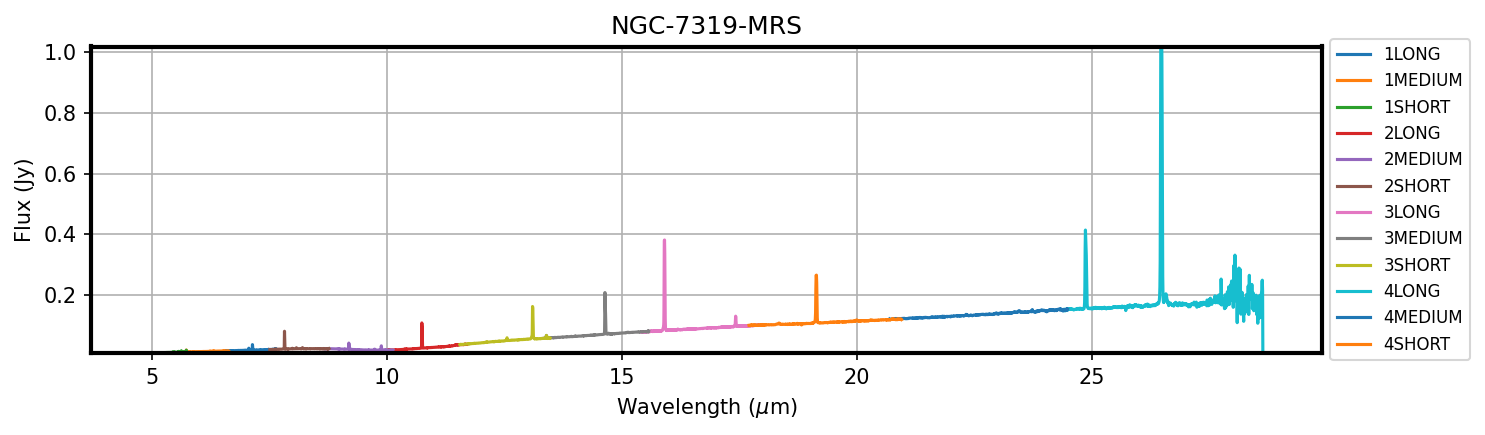

In [39]:
if doviz:
    # Make normal plots
    %matplotlib inline
    # Interactive plots
    #%matplotlib notebook

    rc('axes', linewidth=2)
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=150)

    if (len(x1dfiles) > 0):
        hdu = fits.open(x1dfiles[0])
        objname = hdu[0].header['TARGPROP']
        hdu.close()
    else:
        objname = 'Unknown'

    ymin, ymax = np.nan, np.nan
    for file in x1dfiles:
        x1d = fits.open(file)
        x1ddata = x1d[1].data
        wave = x1ddata['WAVELENGTH']
        # MRS x1d files have both regular ('flux') and residual-fringe (RF) corrected ('rf_flux') spectra.
        # The RF-corrected spectra will have NaN values if RF correction was disabled or failed to converge.
        # Plot the RF corrected spectrum if available, otherwise plot the regular spectrum.
        if (np.nansum(x1ddata['RF_FLUX']) != 0):
            flux = x1ddata['RF_FLUX']
        else:
            flux = x1ddata['FLUX']
        ymin = np.nanmin([ymin, np.nanpercentile(flux, 2)])
        ymax = np.nanmax([ymax, np.nanpercentile(flux, 99.5)])

        # labels
        label = x1d[0].header['CHANNEL'] + x1d[0].header['BAND']

        plt.plot(wave, flux, label=label)

        x1d.close()

    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel('Flux (Jy)')
    plt.title(objname)
    plt.ylim(ymin, ymax)
    plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.tight_layout()
    plt.savefig('mrs_example_plot.png')

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 